In [ ]:
# lib installations:
!pip install scikeras
!pip install tensorflow
!pip install seaborn

In [ ]:
# imports and constants:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from functools import partial
# Set global random seeds
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Ensure deterministic behavior in TensorFlow
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

RANDOM_SEED = 42

In [ ]:
# Question1 -fetch dataset from kagger to env:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

100%|██████████| 172k/172k [00:00<00:00, 38.9MB/s]

Extracting files...


In [ ]:
# show original df:
file_name = os.listdir(path)[0]
original_df = pd.read_csv(os.path.join(path, file_name))
df = original_df.copy()
print(original_df.shape)
original_df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Question 10b-increase data by 50%
# Step 3: Increase the number of records by 50%
num_records_to_add = int(0.5 * len(original_df))
new_records = original_df.sample(n=num_records_to_add, replace=True).reset_index(drop=True)

# Modify the sampled records slightly
numeric_columns = original_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    new_records[col] += np.random.normal(0, 0.1 * new_records[col].std(), size=num_records_to_add)

# Combine original and new records
extended_df = pd.concat([original_df, new_records], ignore_index=True)
print(extended_df.shape)


(10564, 21)


In [ ]:
# galit-reduce data
# Step 3: Decrease the number of records by
num_records_to_retain = int(0.02 * len(original_df))
reduced_df = original_df.sample(n=num_records_to_retain, random_state=42).reset_index(drop=True)
print(reduced_df.shape)

(140, 21)


In [ ]:
choice=0 #original data
if choice==1: #increase data
   df=extended_df
elif choice==2:#decrease data
    df= reduced_df

In [ ]:
print(df.shape)

(7043, 21)


In [ ]:
# Question 3a -Step 1: Overview of the dataset
print("Dataset Shape:", original_df.shape)
print("Columns and Data Types:\n", original_df.info())
print("\nMissing Values:\n", original_df.isnull().sum())
print("\nDuplicate Rows:", original_df.duplicated().sum())

Dataset Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [ ]:
#Question 3b- Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Series([], dtype: int64)


<ipython-input-9-6e1f40729a48>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


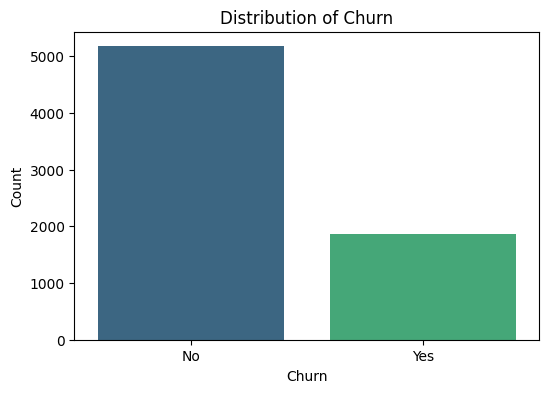

In [ ]:
# Question 2a-EDA-Distribution of target variable (Churn)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title("Distribution of Churn")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

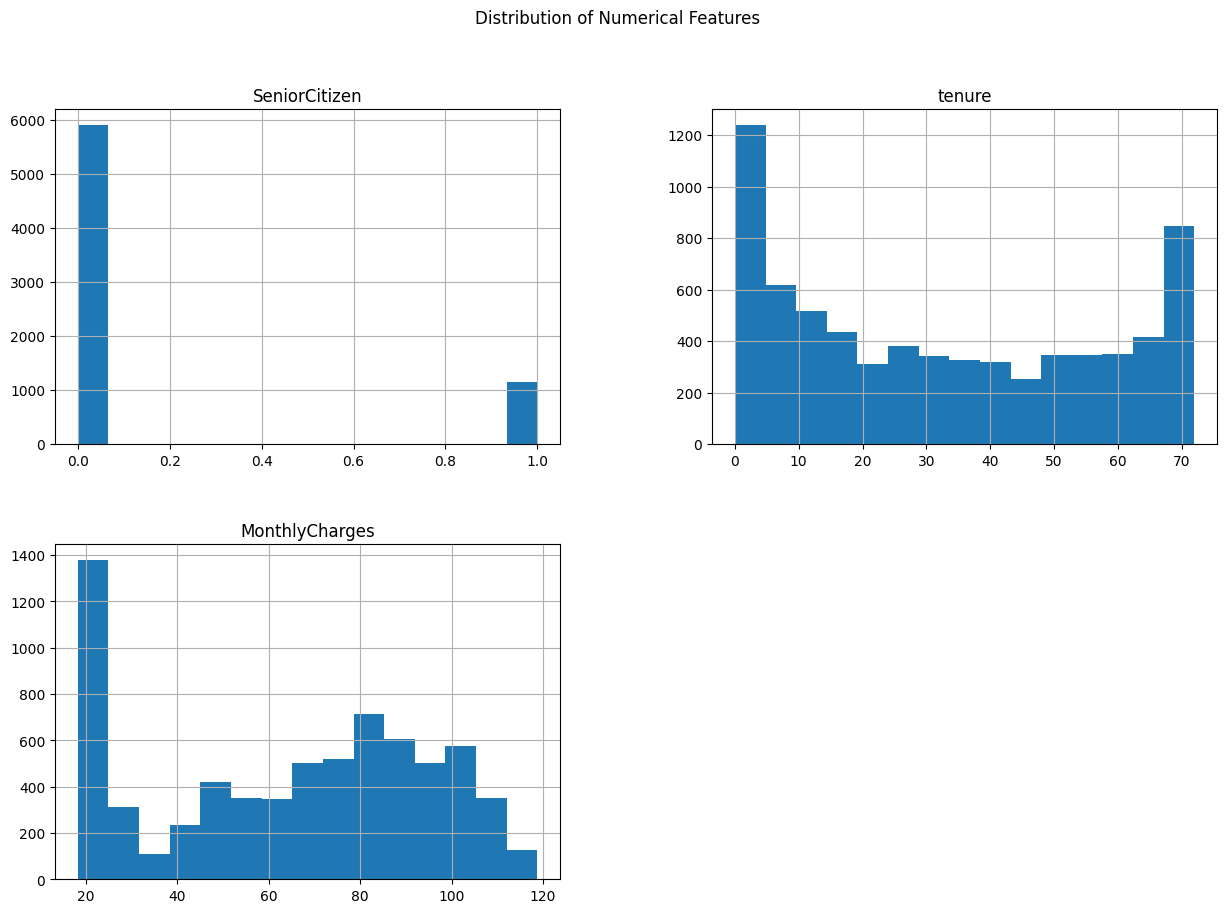

In [ ]:
# Question 2b-EDA-Distribution of Numerical Features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

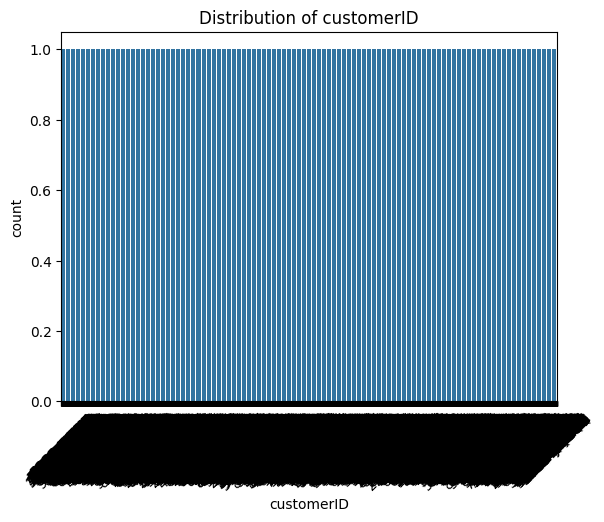

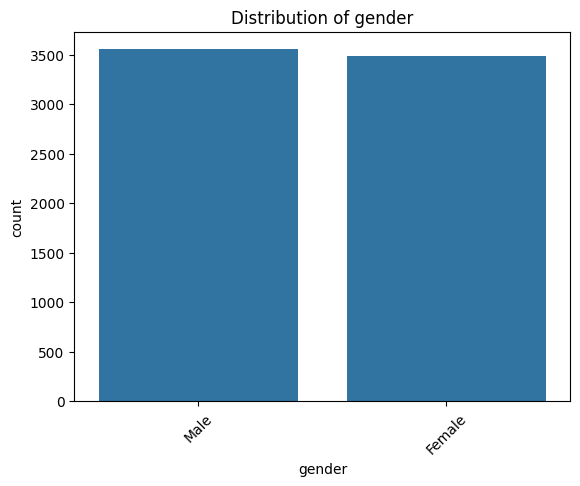

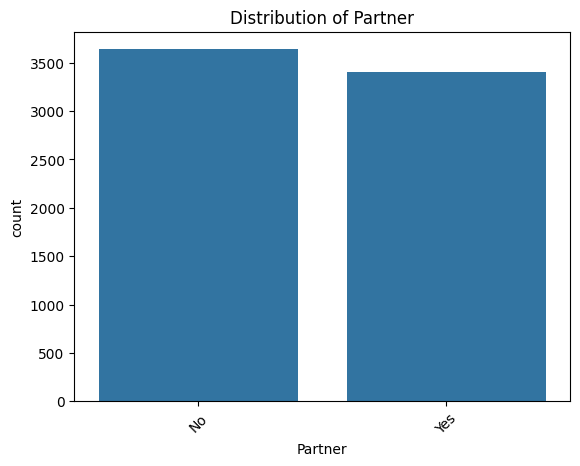

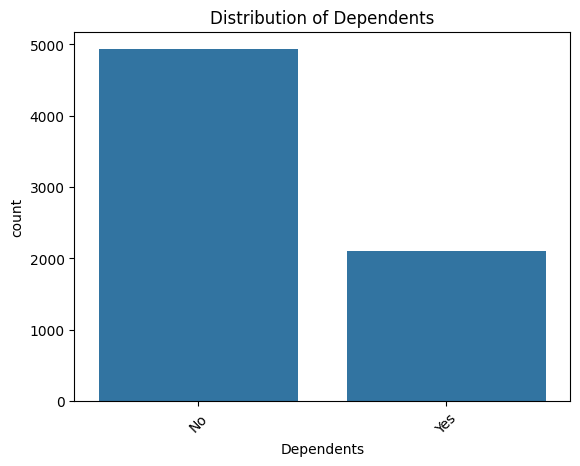

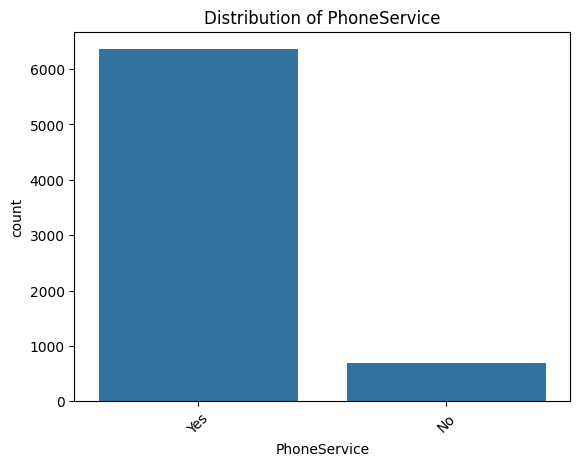

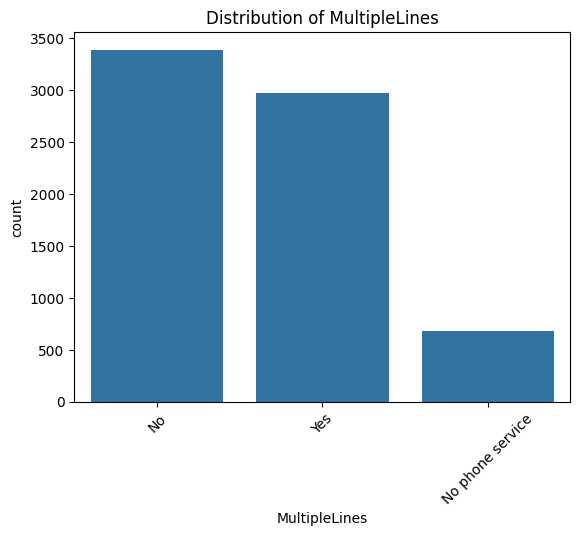

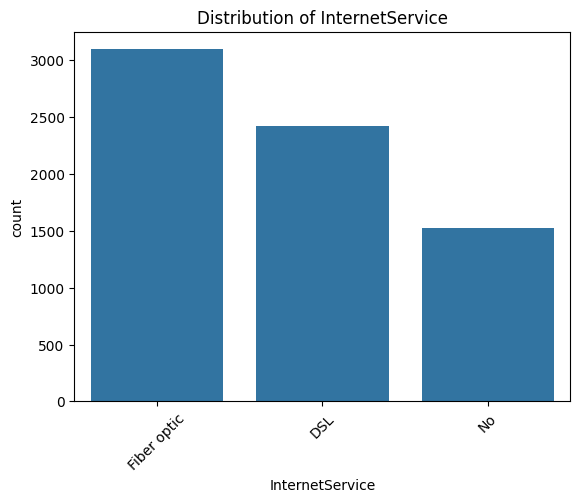

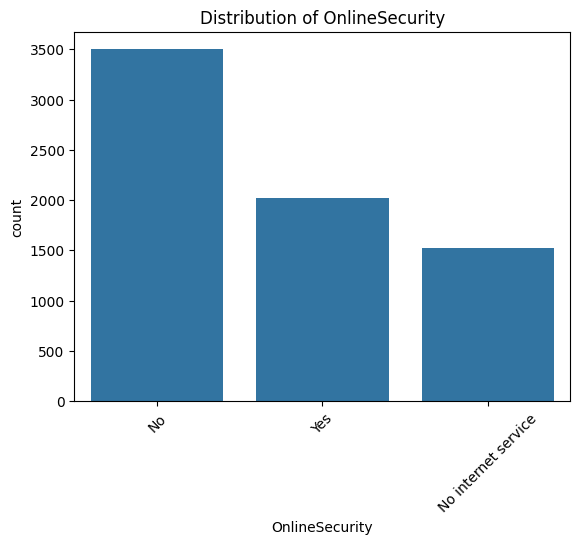

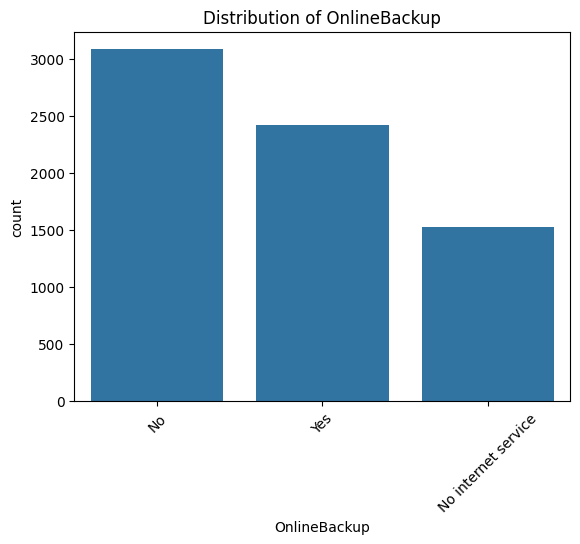

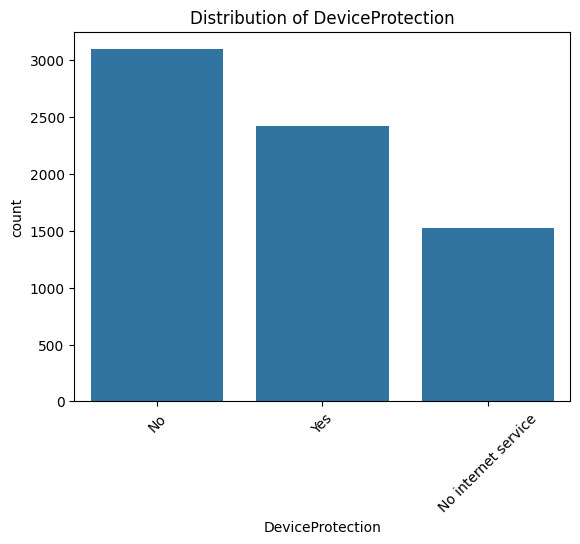

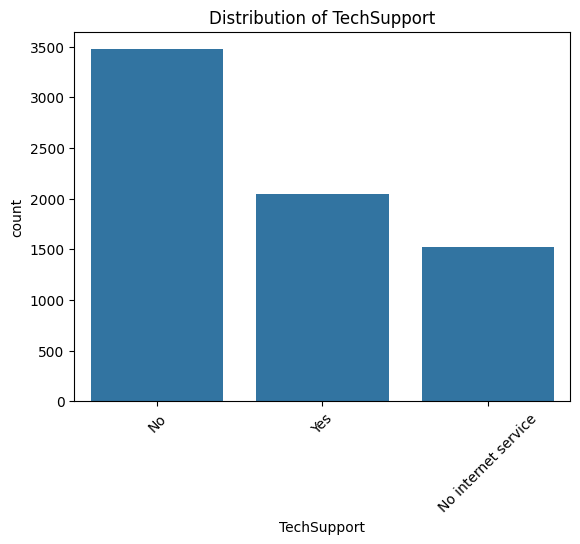

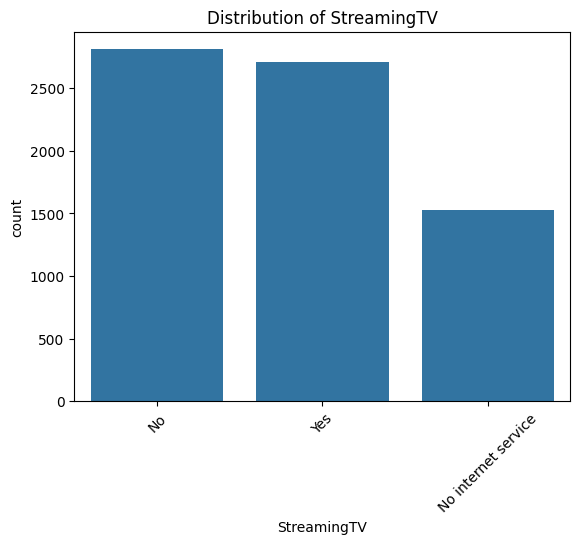

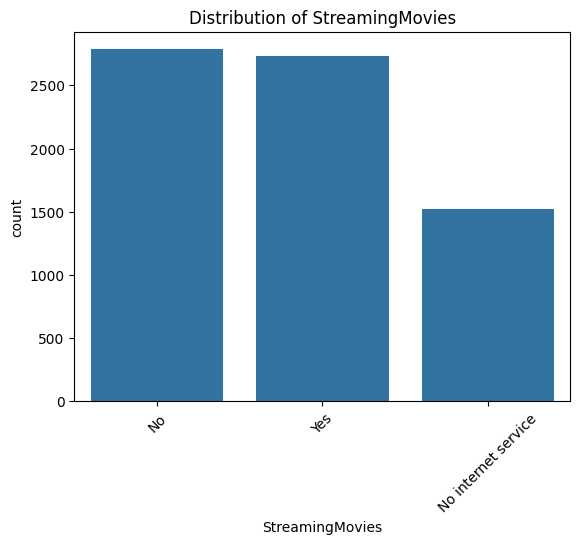

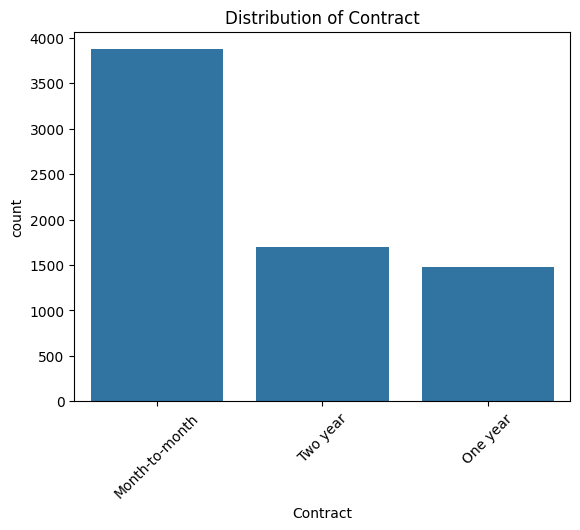

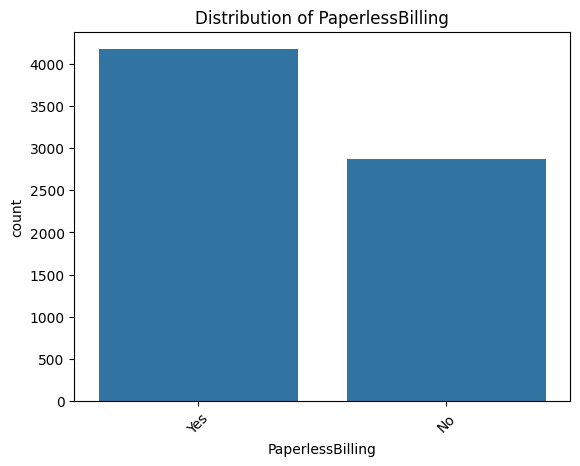

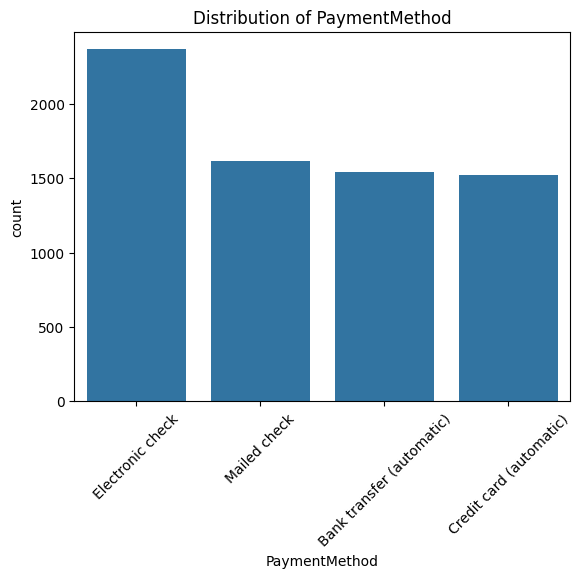

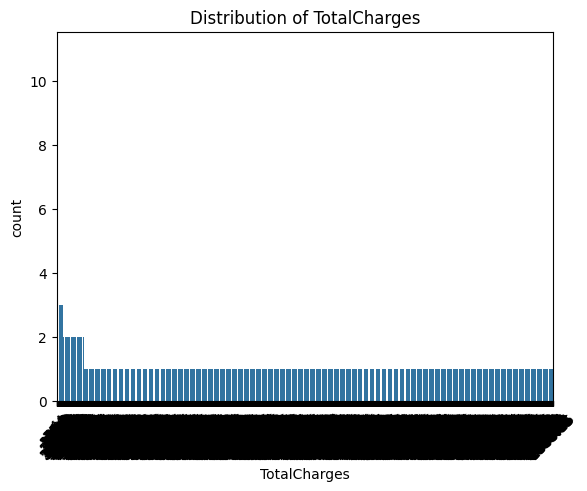

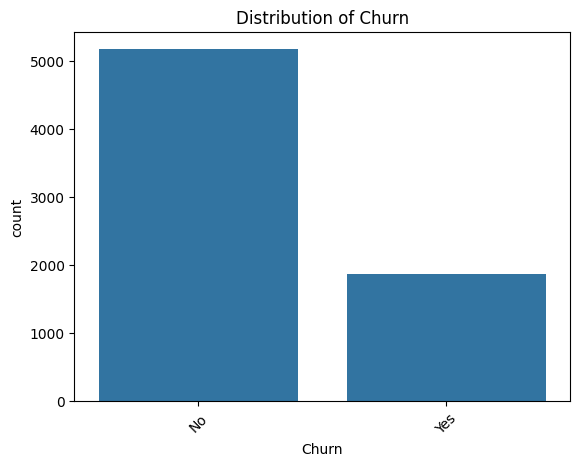

In [ ]:
#Question 2c-EDA- Distribution of Categorical Features
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


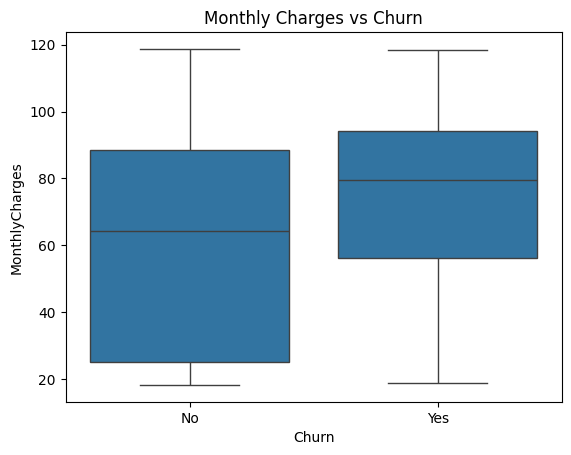

In [ ]:
#Question 2d EDA-relation between features and churn
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges vs Churn')
plt.show()

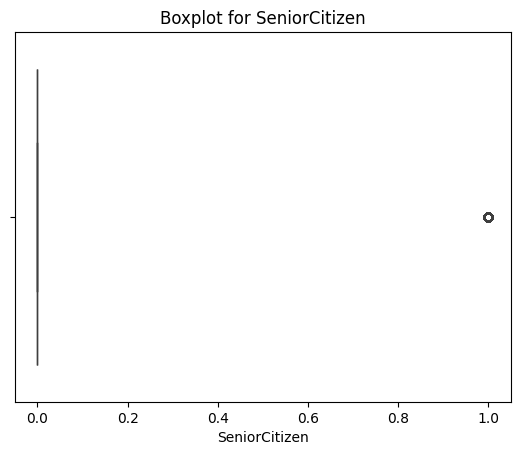

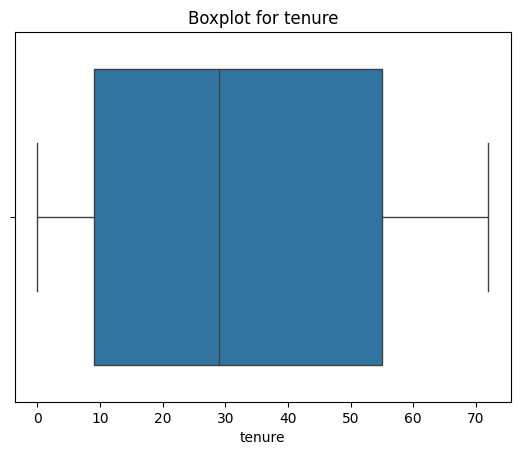

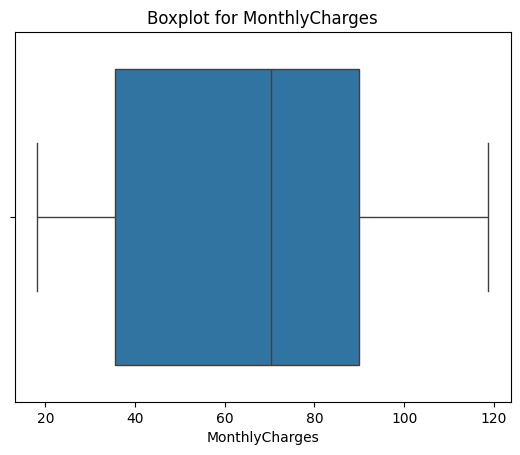

In [ ]:
# Question 2e-EDA-Check for Outliers (Boxplots)
for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


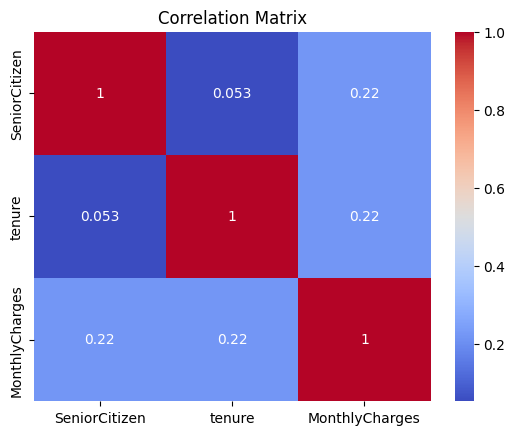

In [ ]:
#Question 2f-EDA-correlation heatmap

numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation = numerical_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#Question 3c PREPROCESSING:
# clean df:

scaler = MinMaxScaler()

# remove columns that are almost constants
df = df[[col for col in df.columns if df[col].nunique() <= 7000]]


# fill na  for numerical and categorical columns
numerical_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(exclude='number').columns
df.loc[:, numerical_columns] = df[numerical_columns].astype(float)

df.loc[:, numerical_columns] = df[numerical_columns].fillna(0.0)
df.loc[:, categorical_columns] = df[categorical_columns].fillna('')

clean_df = df.copy()

# encode daata
for col in categorical_columns:
    unique_values = df[col].dropna().unique()
    if len(unique_values) == 2:
        value_map = {unique_values[0]: 0, unique_values[1]: 1}
        df.loc[:, col] = df[col].map(value_map)
    else:
        encoder = LabelEncoder()
        df.loc[:, col] = encoder.fit_transform(df[col])

# scale data: normalization
df.loc[:, numerical_columns] = scaler.fit_transform(df[numerical_columns])

df['Churn'] = df['Churn'].astype(int)
df.head()

<ipython-input-7-d5e96d42e3ba>:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01388889 0.47222222 0.02777778 ... 0.15277778 0.05555556 0.91666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numerical_columns] = scaler.fit_transform(df[numerical_columns])
<ipython-input-7-d5e96d42e3ba>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Churn'] = df['Churn'].astype(int)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,0.013889,0,1,0,0,2,0,0,0,0,0,0,2,0.115423,2505,0
1,1,0,1,0,0.472222,1,0,0,2,0,2,0,0,0,1,1,3,0.385075,1466,0
2,1,0,1,0,0.027778,1,0,0,2,2,0,0,0,0,0,0,3,0.354229,157,1
3,1,0,1,0,0.625000,0,1,0,2,0,2,2,0,0,1,1,0,0.239303,1400,0
4,0,0,1,0,0.027778,1,0,1,0,0,0,0,0,0,0,0,2,0.521891,925,1


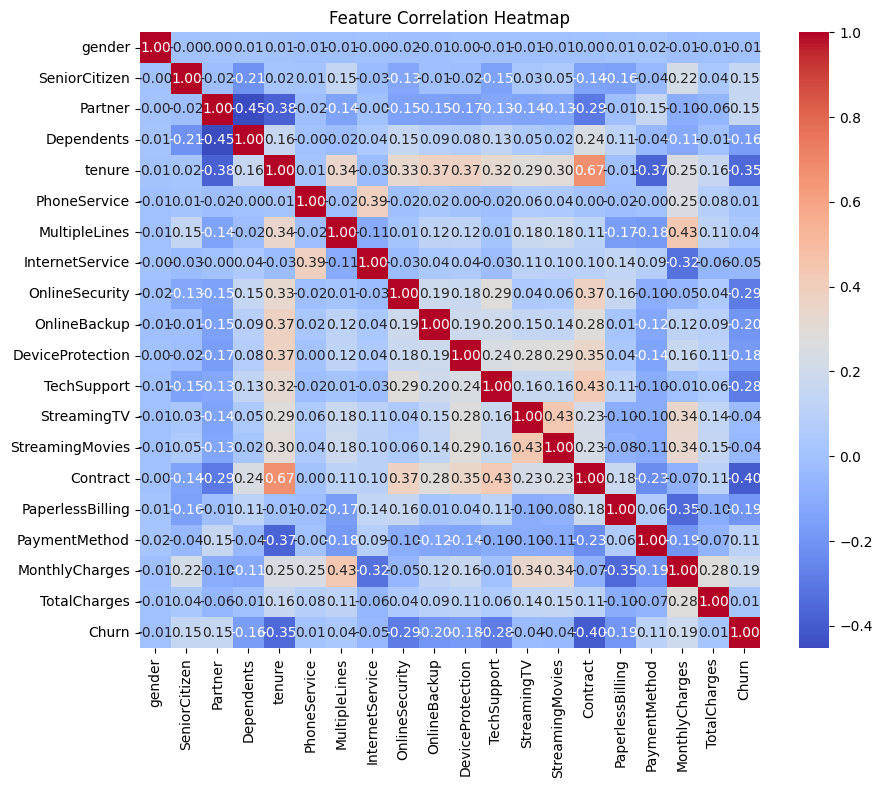

In [ ]:
#Question 3d
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
#Question3d
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print(f"Columns with correlations > 0.9:")
print(high_corr_pairs)

Columns with correlations > 0.9:
[]


In [ ]:
correlations = df.corr()["Churn"]
low_corr_columns = correlations[abs(correlations) < 0.1].index.tolist()
print(f"Columns with correlation to Churn < 0.01:")
print(low_corr_columns)

Columns with correlation to Churn < 0.01:
['gender', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies', 'TotalCharges']


In [ ]:
df = df.drop(columns=low_corr_columns, axis=1)
df.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0,0,0.013889,0,2,0,0,0,0,2,0.115423,0
1,0,1,0,0.472222,2,0,2,0,1,1,3,0.385075,0
2,0,1,0,0.027778,2,2,0,0,0,0,3,0.354229,1
3,0,1,0,0.625000,2,0,2,2,1,1,0,0.239303,0
4,0,1,0,0.027778,0,0,0,0,0,0,2,0.521891,1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


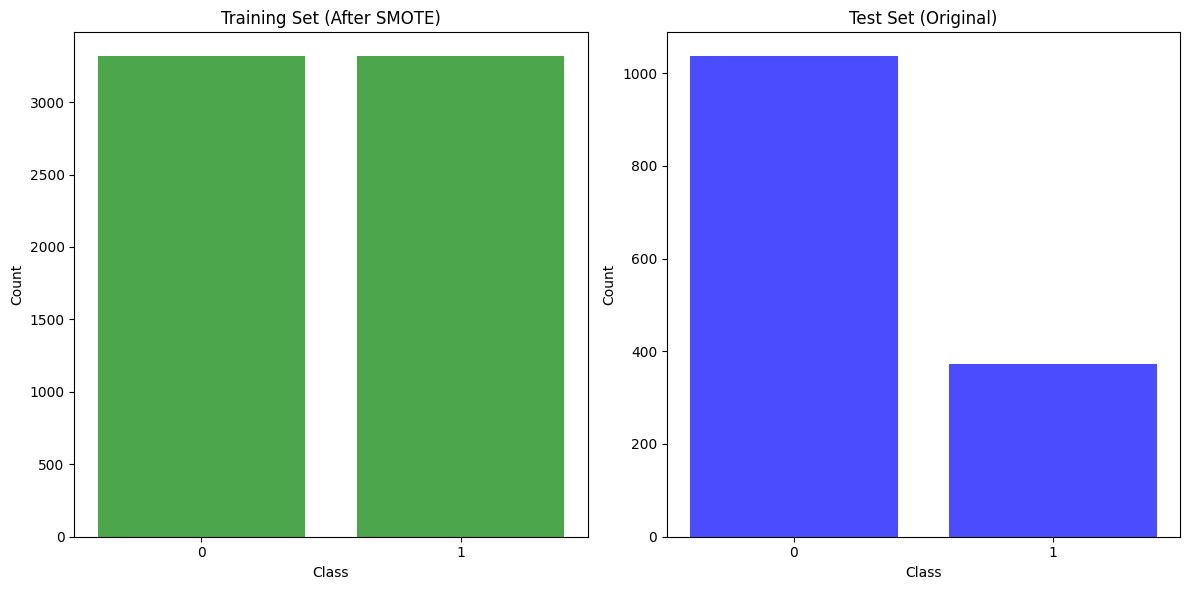

In [ ]:
# Question 4 -basic data splits:
test_size = 0.2

train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=RANDOM_SEED)

x_test = test_df.drop(columns=['Churn'])
y_test = test_df['Churn']

train_df, val_df = train_test_split(train_val_df, test_size=test_size, random_state=RANDOM_SEED)

x_train = train_df.drop(columns=['Churn'])
y_train = train_df['Churn']

# data balancing for training
smote = SMOTE(sampling_strategy=1.0, random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

# Compute class distributions
train_dist_after_smote = pd.Series(y_train).value_counts()
test_dist = y_test.value_counts()

# Plot class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot train set (after SMOTE)
axes[0].bar(train_dist_after_smote.index, train_dist_after_smote.values, color='green', alpha=0.7)
axes[0].set_title("Training Set (After SMOTE)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].set_xticks(train_dist_after_smote.index)

# Plot test set
axes[1].bar(test_dist.index, test_dist.values, color='blue', alpha=0.7)
axes[1].set_title("Test Set (Original)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].set_xticks(test_dist.index)

plt.tight_layout()
plt.show()

x_val = val_df.drop(columns=['Churn'])
y_val = val_df['Churn']

Classic Model:

In [ ]:
#Question 5- decision tree
base_model = DecisionTreeClassifier(random_state=42)
base_model.fit(x_train, y_train)

y_train_pred = base_model.predict(x_train)
print("Validation Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nValidation Classification Report:\n", classification_report(y_train, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = base_model.predict(x_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = base_model.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.998341375150784

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3316
           1       1.00      1.00      1.00      3316

    accuracy                           1.00      6632
   macro avg       1.00      1.00      1.00      6632
weighted avg       1.00      1.00      1.00      6632

--------------------------------------------------------
Validation Accuracy: 0.7249334516415262

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       822
           1       0.49      0.52      0.51       305

    accuracy                           0.72      1127
   macro avg       0.66      0.66      0.66      1127
weighted avg       0.73      0.72      0.73      1127

--------------------------------------------------------
Test Accuracy: 0.7224982256919801

Test Classification Report:
               pre

Hyper parameters Classic Model:

In [ ]:
# Question6 -best decision found by tuninng hyper params:

param_grid = {
    'max_depth': [10, 20, 30,],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None],
    # 'criterion': ['gini', 'entropy'],
    # 'splitter': ['best', 'random'],
}

optimized_model = DecisionTreeClassifier(random_state=RANDOM_SEED)

model_random = RandomizedSearchCV(
    estimator=optimized_model,
    param_distributions=param_grid,
    random_state=RANDOM_SEED,
)

model_random.fit(x_train, y_train)

print("Best Parameters for DecisionTreeClassifier:", model_random.best_params_)
print('--------------------------------------------------------')
best_base_model = model_random.best_estimator_

y_train_pred = best_base_model.predict(x_train)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = best_base_model.predict(x_val)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = best_base_model.predict(x_test)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Best Parameters for DecisionTreeClassifier: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
--------------------------------------------------------

Train Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.85      3316
           1       0.83      0.89      0.86      3316

    accuracy                           0.85      6632
   macro avg       0.85      0.85      0.85      6632
weighted avg       0.85      0.85      0.85      6632

--------------------------------------------------------

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81       822
           1       0.52      0.65      0.58       305

    accuracy                           0.74      1127
   macro avg       0.69      0.71      0.69      1127
weighted avg       0.76      0.74      0.75      1127

-------------------------------------------------------

Neural Network:

In [ ]:
print(df.shape)

(7043, 13)


In [ ]:
# Question 7-basic NN:
threshold = 0.4

base_deep_model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

base_deep_model.compile(loss='binary_crossentropy')

base_deep_model.fit(x_train, y_train,
                    validation_data=(x_val, y_val))

print("\nbasic nn report")
y_train_pred = (base_deep_model.predict(x_train) > threshold).astype(int)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = (base_deep_model.predict(x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = (base_deep_model.predict(x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5468 - val_loss: 0.4767

basic nn report
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Train Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      3316
           1       0.73      0.84      0.78      3316

    accuracy                           0.76      6632
   macro avg       0.77      0.76      0.76      6632
weighted avg       0.77      0.76      0.76      6632

--------------------------------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.78       822
           1       0.49      0.78      0.60       305

    accuracy                           0.72      1127
   macro avg       0.69      0.74      0.69      1127
weighted avg       0.79      0.72      0.74      1127

--------------------------------------------------

In [ ]:
# Question 9a-basic NN with dropout:

base_deep_model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')

])

base_deep_model.compile(loss='binary_crossentropy')

base_deep_model.fit(x_train, y_train,
                    validation_data=(x_val, y_val))

print("\nbasic nn report with dopout")
y_train_pred = (base_deep_model.predict(x_train) > threshold).astype(int)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = (base_deep_model.predict(x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = (base_deep_model.predict(x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5622 - val_loss: 0.4768

basic nn report with dopout
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74      3316
           1       0.72      0.84      0.78      3316

    accuracy                           0.76      6632
   macro avg       0.77      0.76      0.76      6632
weighted avg       0.77      0.76      0.76      6632

--------------------------------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.78       822
           1       0.48      0.79      0.60       305

    accuracy                           0.71      1127
   macro avg       0.69      0.74      0.69      1127
weighted avg       0.78      0.71      0.73      1127

-------------------------------------

In [ ]:
# Question 9b-basic NN variations - change regularization by variations of drop rates:


for drop_rate in [0.1, 0.3, 0.5]:
  base_deep_model_2 = Sequential([
      Input(shape=(x_train.shape[1],)),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dropout(drop_rate),
      Dense(1, activation='sigmoid')
  ])

  base_deep_model.compile(loss='binary_crossentropy')

  base_deep_model.fit(x_train, y_train,
                      validation_data=(x_val, y_val))

  print(f"Drop Rate = {drop_rate}")
  y_train_pred = (base_deep_model.predict(x_train) > threshold).astype(int)
  print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
  print('--------------------------------------------------------')
  y_val_pred = (base_deep_model.predict(x_val) > threshold).astype(int)
  print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
  print('--------------------------------------------------------')
  y_test_pred = (base_deep_model.predict(x_test) > threshold).astype(int)
  print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4980 - val_loss: 0.4792
Drop Rate = 0.1
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.74      3316
           1       0.73      0.85      0.78      3316

    accuracy                           0.76      6632
   macro avg       0.77      0.76      0.76      6632
weighted avg       0.77      0.76      0.76      6632

--------------------------------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       822
           1       0.48      0.79      0.60       305

    accuracy                           0.72      1127
   macro avg       0.69      0.74      0.69      1127
weighted avg       0.79      0.72      0.73      1127

---------------------------------------------------

In [ ]:
# Question 9c-basic NN variations - change first dense unites:


for layer_unites in [64, 128, 256]:
  base_deep_model_2 = Sequential([
      Input(shape=(x_train.shape[1],)),
      Dense(layer_unites, activation='relu'),
      Dense(64, activation='relu'),
     # Dropout(0.3),
      Dense(1, activation='sigmoid')
  ])

  base_deep_model.compile(loss='binary_crossentropy')

  base_deep_model.fit(x_train, y_train,
                      validation_data=(x_val, y_val))

  print(f"Layer unit = {layer_unites}")
  y_train_pred = (base_deep_model.predict(x_train) > threshold).astype(int)
  print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
  print('--------------------------------------------------------')
  y_val_pred = (base_deep_model.predict(x_val) > threshold).astype(int)
  print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
  print('--------------------------------------------------------')
  y_test_pred = (base_deep_model.predict(x_test) > threshold).astype(int)
  print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4765 - val_loss: 0.4783
Layer unit = 64
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      3316
           1       0.74      0.86      0.80      3316

    accuracy                           0.78      6632
   macro avg       0.79      0.78      0.78      6632
weighted avg       0.79      0.78      0.78      6632

--------------------------------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78       822
           1       0.48      0.77      0.59       305

    accuracy                           0.71      1127
   macro avg       0.69      0.73      0.69      1127
weighted avg       0.78      0.71      0.73      1127

---------------------------------------------------

In [ ]:
# Question 9d-basic NN variations - change learning_rate:

for lr in [0.01, 0.001, 0.0001]:
  base_deep_model_2 = Sequential([
      Input(shape=(x_train.shape[1],)),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
    #  Dropout(0.3),
      Dense(1, activation='sigmoid')
  ])

  base_deep_model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy')

  base_deep_model.fit(x_train, y_train,
                      validation_data=(x_val, y_val))

  print(f"Learning rate Rate = {lr}")
  y_train_pred = (base_deep_model.predict(x_train) > threshold).astype(int)
  print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
  print('--------------------------------------------------------')
  y_val_pred = (base_deep_model.predict(x_val) > threshold).astype(int)
  print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
  print('--------------------------------------------------------')
  y_test_pred = (base_deep_model.predict(x_test) > threshold).astype(int)
  print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5035 - val_loss: 0.4897
Learning rate Rate = 0.01
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.61      0.71      3316
           1       0.70      0.89      0.78      3316

    accuracy                           0.75      6632
   macro avg       0.77      0.75      0.75      6632
weighted avg       0.77      0.75      0.75      6632

--------------------------------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.63      0.74       822
           1       0.45      0.82      0.58       305

    accuracy                           0.68      1127
   macro avg       0.68      0.72      0.66      1127
weighted avg       0.78      0.68      0.70      1127

----------------------------------------

---------------

In [ ]:
import numpy as np
import itertools
#Question 9e
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

# Perform manual search
best_model = None
best_params = None
best_score = -np.inf  # Initialize to negative infinity
results = []

# Iterate over all combinations of hyperparameters
for learning_rate, batch_size, epochs in itertools.product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['epochs']
):
    print(f"Testing combination: LR={learning_rate}, Batch Size={batch_size}, Epochs={epochs}")

    # Create the model
    model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate on validation set
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    results.append((learning_rate, batch_size, epochs, val_accuracy))

    # Update best model if the current one performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_model = model
        best_params = (learning_rate, batch_size, epochs)

# Report the best parameters and results
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_params[0]}, Batch Size: {best_params[1]}, Epochs: {best_params[2]}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate the best model on test data
y_test_pred = (best_model.predict(x_test) > 0.5).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Testing combination: LR=0.01, Batch Size=16, Epochs=10
Epoch 1/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7228 - loss: 0.5403 - val_accuracy: 0.7569 - val_loss: 0.4671
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7581 - loss: 0.4949 - val_accuracy: 0.7640 - val_loss: 0.4693
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7624 - loss: 0.4932 - val_accuracy: 0.7436 - val_loss: 0.4930
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7645 - loss: 0.4851 - val_accuracy: 0.7445 - val_loss: 0.4904
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7633 - loss: 0.4847 - val_accuracy: 0.7436 - val_loss: 0.5055
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7737 - loss: 0.4787 - val_accuracy: 0.7480 - val_loss: 0.5152
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7711 - loss: 0.4751 - val_accuracy: 0.7311 - val_loss: 0.5121
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

In [ ]:
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_params[0]}, Batch Size: {best_params[1]}, Epochs: {best_params[2]}")


Best Hyperparameters:
Learning Rate: 0.001, Batch Size: 16, Epochs: 30


In [ ]:
# best version by hyper parameters optimization:
#Question 11-accuracy reduce
best_learning_rate, best_batch_size, best_epochs = best_params

model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# making the training data heavly skewed toward target = 1
only_churn = train_df[train_df['Churn'] == 1]
x_train_churn_1 = only_churn.drop(columns=['Churn'])
y_train_churn_1 = only_churn['Churn']

history = model.fit(
    x_train_churn_1, y_train_churn_1,
    validation_data=(x_val, y_val),
    batch_size=best_batch_size,
    epochs=best_epochs,
    verbose=1
)

y_train_pred = (model.predict(x_train_churn_1) > threshold).astype(int)
print("\Train Classification Report:\n", classification_report(y_train_churn_1, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = (model.predict(x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = (model.predict(x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9367 - loss: 0.2739 - val_accuracy: 0.2706 - val_loss: 5.8576
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.2706 - val_loss: 7.7727
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.2706 - val_loss: 8.9366
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 8.7693e-04 - val_accuracy: 0.2706 - val_loss: 9.9548
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0597e-04 - val_accuracy: 0.2706 - val_loss: 10.7283
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8419e-04 - val_accuracy: 0.2706 - val_loss: 11.3836
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.2642e-04 - val_accuracy: 0.2706 - val_loss: 12.0389
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5059e-04 - val_accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1036
           1       0.26      1.00      0.42       373

    accuracy                           0.26      1409
   macro avg       0.13      0.50      0.21      1409
weighted avg       0.07      0.26      0.11      1409



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Question 10a- best version by hyper parameters optimization:increase accuracy
model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class_0 = train_df[train_df['Churn'] == 0]
class_1 = train_df[train_df['Churn'] == 1]

# detect outliers
iso = IsolationForest(contamination=0.2, random_state=42)
# Detect outliers for each class
class_0_outliers = iso.fit_predict(class_0.drop(columns=['Churn']))
class_1_outliers = iso.fit_predict(class_1.drop(columns=['Churn']))

# Filter out outliers (keep only non-outliers, i.e., where prediction == 1)
class_0_cleaned = class_0[class_0_outliers == 1]
class_1_cleaned = class_1[class_1_outliers == 1]

# Combine cleaned subsets
cleaned_training_df = pd.concat([class_0_cleaned, class_1_cleaned])

# Separate features and labels
x_train_cleaned = cleaned_training_df.drop(columns=['Churn'])
y_train_cleaned = cleaned_training_df['Churn']

history = model.fit(
    x_train_cleaned, y_train_cleaned,
    validation_data=(x_val, y_val),
    batch_size=best_batch_size,
    epochs=best_epochs,
    verbose=1
)

y_train_pred = (model.predict(x_train_cleaned) > threshold).astype(int)
print("\Train Classification Report:\n", classification_report(y_train_cleaned, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = (model.predict(x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = (model.predict(x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7559 - loss: 0.4513 - val_accuracy: 0.7870 - val_loss: 0.4836
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8122 - loss: 0.3585 - val_accuracy: 0.7915 - val_loss: 0.5071
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8128 - loss: 0.3533 - val_accuracy: 0.7950 - val_loss: 0.5124
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8215 - loss: 0.3456 - val_accuracy: 0.7950 - val_loss: 0.5127
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8166 - loss: 0.3433 - val_accuracy: 0.7870 - val_loss: 0.5140
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8258 - loss: 0.3425 - val_accuracy: 0.7888 - val_loss: 0.5191
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8211 - loss: 0.3413 - val_accuracy: 0.7950 - val_loss: 0.5190
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8216 - loss: 0.3363 - val_accuracy: 0.

a small downrage in recall of class 0 but small improvments in precision in both calsses and the recall of class 1

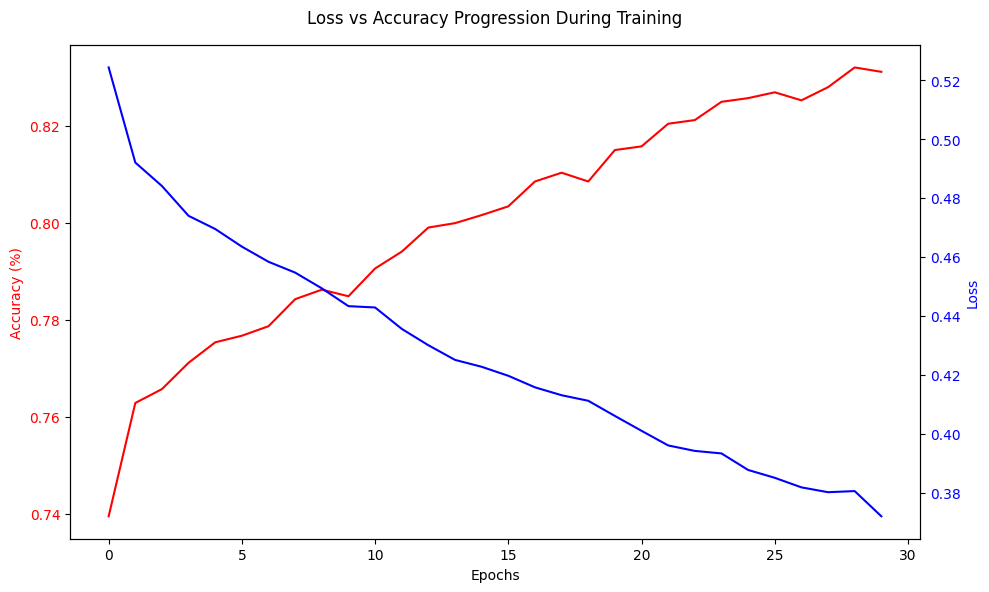

In [ ]:
#Question 13-testinf with accuracy vs loss
# Define the model
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=best_epochs,  # Example epoch count
    batch_size=best_batch_size,
    validation_data=(x_val, y_val),
    verbose=0  # Suppress detailed output
)

# Assuming `history` is the result of model.fit()
# Extract metrics
epochs = range(len(history.history['loss']))  # Number of epochs
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot Accuracy and Loss on the same graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Accuracy on the left y-axis
ax1.plot(epochs, accuracy, 'r-', label="Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy (%)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create second y-axis for Loss
ax2 = ax1.twinx()
ax2.plot(epochs, loss, 'b-', label="Loss")
ax2.set_ylabel("Loss", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and Legend
fig.suptitle("Loss vs Accuracy Progression During Training")
fig.tight_layout()
plt.show()


In [ ]:
# best version with different sampaling ratios:
#Question 14
smote_ratios = [0.5, 0.75, 1.0]  # 0.5: 1 minority to 2 majority, 1.0: equal, 2.0: 2 minority to 1 majority
original_x_train = train_df.drop(columns=['Churn'])
original_y_train = train_df['Churn']

for smote_ratio in smote_ratios:

  smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)
  smote_x_train, smote_y_train = smote.fit_resample(original_x_train, original_y_train)

  smote_model = Sequential([
          Input(shape=(x_train.shape[1],)),
          Dense(128, activation='relu'),
          Dense(64, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')
      ])

  optimizer = Adam(learning_rate=best_learning_rate)
  smote_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = smote_model.fit(
    smote_x_train, smote_y_train,
    validation_data=(x_val, y_val),
    batch_size=best_batch_size,
    epochs=best_epochs,
    verbose=1
  )

  print(f"Smote ratio = {smote_ratio}")
  y_train_pred = (smote_model.predict(x_train) > threshold).astype(int)
  print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
  print('--------------------------------------------------------')
  y_val_pred = (smote_model.predict(x_val) > threshold).astype(int)
  print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
  print('--------------------------------------------------------')
  y_test_pred = (smote_model.predict(x_test) > threshold).astype(int)
  print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7154 - loss: 0.5423 - val_accuracy: 0.7791 - val_loss: 0.4560
Epoch 2/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7585 - loss: 0.4860 - val_accuracy: 0.7906 - val_loss: 0.4476
Epoch 3/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7606 - loss: 0.4744 - val_accuracy: 0.7897 - val_loss: 0.4476
Epoch 4/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7637 - loss: 0.4712 - val_accuracy: 0.7915 - val_loss: 0.4455
Epoch 5/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7673 - loss: 0.4701 - val_accuracy: 0.7906 - val_loss: 0.4471
Epoch 6/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7666 - loss: 0.4648 - val_accuracy: 0.7888 - val_loss: 0.4466
Epoch 7/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7736 - loss: 0.4604 - val_accuracy: 0.7897 - val_loss: 0.4450
Epoch 8/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7707 - loss: 0.4604 - val_accuracy: 0.7870 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7029 - loss: 0.5637 - val_accuracy: 0.7276 - val_loss: 0.5114
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7499 - loss: 0.5054 - val_accuracy: 0.7276 - val_loss: 0.5108
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7528 - loss: 0.4957 - val_accuracy: 0.7436 - val_loss: 0.4982
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7608 - loss: 0.4859 - val_accuracy: 0.7516 - val_loss: 0.4883
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7631 - loss: 0.4829 - val_accuracy: 0.7498 - val_loss: 0.4884
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7628 - loss: 0.4767 - val_accuracy: 0.7507 - val_loss: 0.4826
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7668 - loss: 0.4774 - val_accuracy: 0.7551 - val_loss: 0.4893
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7679 - loss: 0.4727 - val_accuracy: 0.7587 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7115 - loss: 0.5549 - val_accuracy: 0.7445 - val_loss: 0.4905
Epoch 2/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7576 - loss: 0.4941 - val_accuracy: 0.7524 - val_loss: 0.4771
Epoch 3/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7638 - loss: 0.4826 - val_accuracy: 0.7560 - val_loss: 0.4803
Epoch 4/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7685 - loss: 0.4768 - val_accuracy: 0.7524 - val_loss: 0.4845
Epoch 5/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7761 - loss: 0.4729 - val_accuracy: 0.7613 - val_loss: 0.4781
Epoch 6/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7773 - loss: 0.4695 - val_accuracy: 0.7640 - val_loss: 0.4765
Epoch 7/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7803 - loss: 0.4659 - val_accuracy: 0.7551 - val_loss: 0.4869
Epoch 8/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7822 - loss: 0.4585 - val_accuracy: 0.7595 - val_

by sampaling to get a more even typed training data we get better results even when not reaching 1:1: ratio.

In [ ]:
# Question 12a-suggest a architectural change-1
from tensorflow.keras.layers import LeakyReLU

leakyrelu_model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=best_learning_rate)
leakyrelu_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = leakyrelu_model.fit(
  x_train, y_train,
  validation_data=(x_val, y_val),
  batch_size=best_batch_size,
  epochs=best_epochs,
  verbose=1
)

y_train_pred = (leakyrelu_model.predict(x_train) > threshold).astype(int)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))
print('--------------------------------------------------------')
y_val_pred = (leakyrelu_model.predict(x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print('--------------------------------------------------------')
y_test_pred = (leakyrelu_model.predict(x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7288 - loss: 0.5512 - val_accuracy: 0.7533 - val_loss: 0.4814
Epoch 2/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7587 - loss: 0.4870 - val_accuracy: 0.7445 - val_loss: 0.4861
Epoch 3/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7672 - loss: 0.4822 - val_accuracy: 0.7445 - val_loss: 0.4844
Epoch 4/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7668 - loss: 0.4748 - val_accuracy: 0.7516 - val_loss: 0.4820
Epoch 5/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7709 - loss: 0.4715 - val_accuracy: 0.7542 - val_loss: 0.4824
Epoch 6/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7764 - loss: 0.4671 - val_accuracy: 0.7613 - val_loss: 0.4830
Epoch 7/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7762 - loss: 0.4648 - val_accuracy: 0.7551 - val_loss: 0.4864
Epoch 8/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.4633 - val_accuracy: 0.7604 - val_

Dim reduction:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6802 - auc: 0.7402 - loss: 0.6103 - val_accuracy: 0.7551 - val_auc: 0.8231 - val_loss: 0.4934
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7408 - auc: 0.8129 - loss: 0.5250 - val_accuracy: 0.7347 - val_auc: 0.8214 - val_loss: 0.4972
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7531 - auc: 0.8238 - loss: 0.5124 - val_accuracy: 0.7303 - val_auc: 0.8229 - val_loss: 0.5045
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7571 - auc: 0.8248 - loss: 0.5094 - val_accuracy: 0.7294 - val_auc: 0.8235 - val_loss: 0.5116
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7651 - auc: 0.8387 - loss: 0.4897 - val_accuracy: 0.7445 - val_auc: 0.8250 - val_loss: 0.4996
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7640 - auc: 0.8359 - loss: 0.4951 - val_accuracy: 0.7382 - val_auc: 0.8248 - val_loss: 0.5023
Epoch 7/100
208/208 ━━━━━━━━━━━━━━

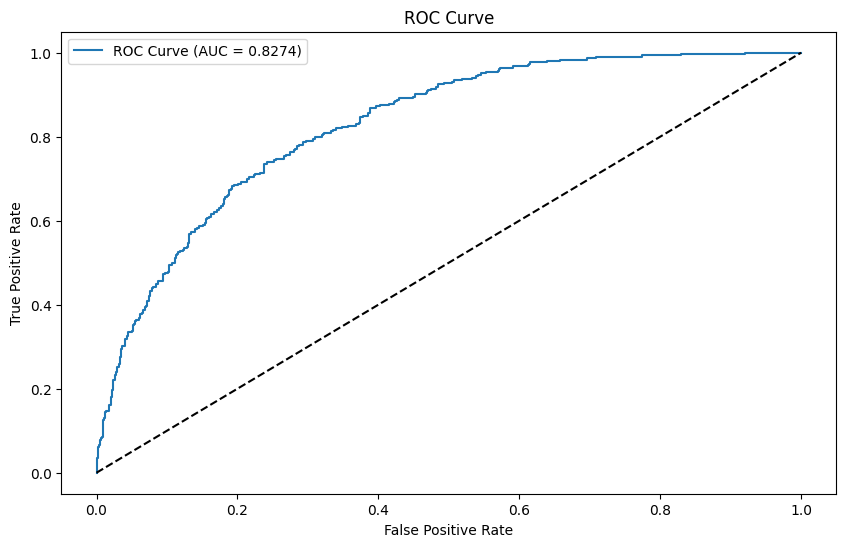

In [ ]:
#Question 12b - suggest a architectural change-2
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, auc

model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Optimizer and Compilation
optimizer = Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# -------------------------
# 🚀 Model Training
# -------------------------

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------
# 📉 Model Evaluation
# -------------------------

# ROC-AUC Threshold Optimization
y_val_probs = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Final Predictions with Optimal Threshold
y_test_probs = model.predict(x_test).ravel()
y_test_pred = (y_test_probs > optimal_threshold).astype(int)

# Evaluation Metrics
print("\nTest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1-Score:", f1_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_probs))

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
#Question 15- PCA from dimintion reduction
x = df.drop(columns=['Churn'])
y = df['Churn']


# data balancing for training
smote = SMOTE(sampling_strategy=1.0, random_state=42)
smote_x_train, smote_y_train = smote.fit_resample(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


        PC1       PC2  Churn
0 -1.167120 -0.463732      0
1  0.304422 -1.463168      0
2 -1.190826 -0.778079      1
3  1.901034 -1.154060      0
4 -2.326528 -0.060253      1


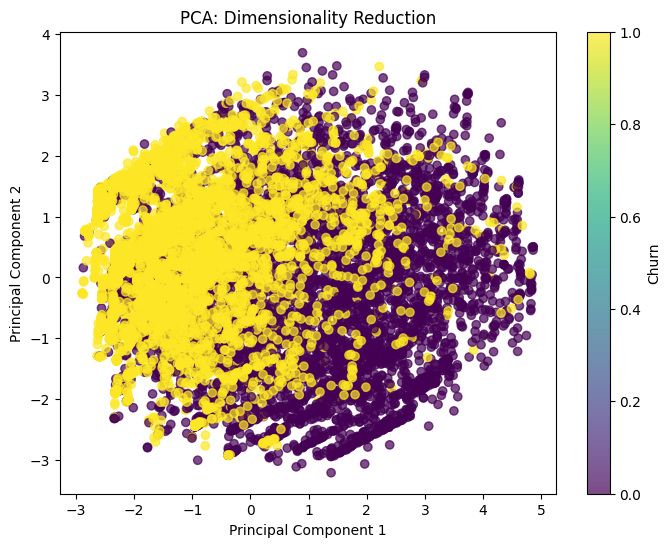

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(smote_x_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Churn'] = smote_y_train

print(pca_df.head())
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Churn'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Churn')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Dimensionality Reduction')
plt.show()

In [ ]:
# basic split on PCAed data
test_size = 0.2

pca_train_val_df, pca_test_df = train_test_split(pca_df, test_size=test_size, random_state=RANDOM_SEED)

pca_x_test = pca_test_df.drop(columns=['Churn'])
pca_y_test = pca_test_df['Churn']


pca_train_df, pca_val_df = train_test_split(pca_train_val_df, test_size=test_size, random_state=RANDOM_SEED)

pca_x_train = pca_train_df.drop(columns=['Churn'])
pca_y_train = pca_train_df['Churn']


pca_x_val = pca_val_df.drop(columns=['Churn'])
pca_y_val = pca_val_df['Churn']

In [ ]:
# basic NN with PCA data

base_deep_model = Sequential([
    Input(shape=(pca_x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

base_deep_model.compile(loss='binary_crossentropy')

base_deep_model.fit(pca_x_train, pca_y_train)


pca_y_train_pred = (base_deep_model.predict(pca_x_train) > threshold).astype(int)
print("\Train Classification Report:\n", classification_report(pca_y_train, pca_y_train_pred))
print('--------------------------------------------------------')
pca_y_val_pred = (base_deep_model.predict(pca_x_val) > threshold).astype(int)
print("\nValidation Classification Report:\n", classification_report(pca_y_val, pca_y_val_pred))
print('--------------------------------------------------------')
pca_y_test_pred = (base_deep_model.predict(pca_x_test) > threshold).astype(int)
print("\nTest Classification Report:\n", classification_report(pca_y_test, pca_y_test_pred))

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5456
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
\Train Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.61      0.70      3331
           1       0.69      0.87      0.77      3291

    accuracy                           0.74      6622
   macro avg       0.76      0.74      0.74      6622
weighted avg       0.76      0.74      0.73      6622

--------------------------------------------------------
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.59      0.69       822
           1       0.68      0.87      0.77       834

    accuracy                           0.73      1656
   macro avg       0.75      0.73      0.73      1656
weighted avg       0.75      0.73      0.73      1656

--------------------------------------------------------
65/65 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
print(df.shape)

(140, 14)


In [ ]:
# Model definition-test reduce data
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping])

# Final Training and Validation Accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.3646 - loss: 0.8405 - val_accuracy: 0.9231 - val_loss: 0.6156
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4823 - loss: 0.7476 - val_accuracy: 0.6538 - val_loss: 0.6897
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6156 - loss: 0.6859 - val_accuracy: 0.2308 - val_loss: 0.7540
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5954 - loss: 0.6488 - val_accuracy: 0.1923 - val_loss: 0.8014
Final Training Accuracy: 0.6058
Final Validation Accuracy: 0.1923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4286 - loss: 0.7120
Test Accuracy: 0.4286


In [ ]:
#Question 10c- Model Definition-test after increase data by 50%
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile Model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Training
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate Model
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6703 - loss: 0.5828 - val_accuracy: 0.7057 - val_loss: 0.6363 - learning_rate: 0.0010
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7534 - loss: 0.4933 - val_accuracy: 0.7555 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7583 - loss: 0.4840 - val_accuracy: 0.7425 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7594 - loss: 0.4790 - val_accuracy: 0.7495 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7649 - loss: 0.4745 - val_accuracy: 0.7585 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.4702 - val_accuracy: 0.7420 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7729 - loss: 0.4632 -